### Movie Review

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # for regex
import matplotlib.pyplot as plt
import seaborn as sns 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [24]:
data = pd.read_csv('IMDB-Dataset.csv')
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


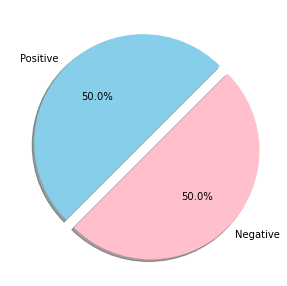

In [26]:
fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=data[data['sentiment']=='positive']
neg=data[data['sentiment']=='negative']
ck=[pos['sentiment'].count(),neg['sentiment'].count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [27]:
data.sentiment.replace('positive',1,inplace=True)
data.sentiment.replace('negative',0,inplace=True)
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [28]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [76]:
import string
def find_website(string):
  
    # findall() has been used 
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)      
    return [x[0] for x in url]



def preprocessor(text):
    
    text = text.lower()
    
    #clean character 
    text=re.sub('<[^>]*>','',text)
    
    ##Add emojis tos the end
    emojis=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text=re.sub('[\W]+',' ',text.lower()) +\
                ' '.join(emojis).replace('-','')
    
    ##removing preposition
    text = ' '.join(word for word in text.split(' ') if word not in string.punctuation)
    
    
    ##remove url
    website = find_website(text)
    #print(website)
    webdomain = []
    
    for web in website:
        text = text.replace(web,' ')
        domain = urlparse(web).netloc
        webdomain.append(domain)
        
    ##removing stop words
    print('removing stop words')
    stop=stopwords.words('english')
    text = [word for word in text.split() if word not in stop]
    text = text + webdomain
    text = ' '.join(text)
    #print(text)
    
    ##Stemming
    porter=PorterStemmer()
    text = [porter.stem(word) for word in text.split()]
    #print(text)
    
    ## Lemitization
    wordnet_lemmatizer = WordNetLemmatizer()
    #temp_df = [wordnet_lemmatizer.lemmatize(w) for w in temp_df]

    return ' '.join(text)
#data['review']=data['review'].apply(preprocessor)

In [77]:
preprocessor('''One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.''')

removing stop words


'one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

<b>Bag of Words</b>

In [81]:
X = np.array(data.iloc[:,0].values)
y = np.array(data.sentiment.values)
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(data.review).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (50000, 1000)
y.shape =  (50000,)


<b> Split train and Test</b>

In [82]:
trainx,testx,trainy,testy = train_test_split(X,y,test_size=0.2,random_state=9)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

Train shapes : X = (40000, 1000), y = (40000,)
Test shapes : X = (10000, 1000), y = (10000,)


<b>Model Building</b>

In [80]:
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

BernoulliNB()

<b>Testing and Validating Model</b>

In [83]:
ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)

print("Gaussian = ",accuracy_score(testy,ypg))
print("Multinomial = ",accuracy_score(testy,ypm))
print("Bernoulli = ",accuracy_score(testy,ypb))

Gaussian =  0.8186
Multinomial =  0.8121
Bernoulli =  0.813
